# Import necessary libraries

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from datetime import datetime

import project3_utilities as p3utils

# Load the Data

In [2]:
ticker_symbol = input("Choose a stock ticker symbol: ")

# Capture the runtime so we can use it for reference later, that way when
# the model and the other outputs are saved, they have a common reference.
unixtime = int(datetime.now().timestamp())
print("The Unixtime ID of this run is: ", unixtime)

# Pull the stock data from Yahoo! Finance
stock_df = yf.Ticker(ticker_symbol).history(period='max')
display(stock_df.head())

# Because I'm paranoid about getting API banned, write this data to a file.
stock_df.to_csv(f'Stock_Data/{ticker_symbol}-YahooData-{unixtime}.csv')

# Load the data
#stock_df = pd.read_csv('Stock_Data/TSLA-YahooData-1722104572.csv')

The Unixtime ID of this run is:  1722545643


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0


# Split the train/test data, build the model, train and predict.

In [16]:
# Get the predictions
(predictions, model, predicted_next_day_close, rmse) \
    = p3utils.get_LSTM_predictions(df=stock_df, 
                                   train_test_split=0.80, 
                                    window_size=90,
                                    batch_size=10,
                                    epochs=5,
                                    verbose=1,
                                    layer1_nodes=64,
                                    layer2_nodes=64,
                                    layer3_nodes=64)

model.summary()
print("Root Mean Square Error (RMSE): ", rmse)

# Save the model
model.save(f'Saved_Models/{ticker_symbol}-Model-{unixtime}.keras')

Epoch 1/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - loss: 0.0052
Epoch 2/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - loss: 0.0016
Epoch 3/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - loss: 8.1087e-04
Epoch 4/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - loss: 8.3329e-04
Epoch 5/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - loss: 8.4792e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


ValueError: Input contains NaN.

In [12]:
# add the predicted day on to the end of the predictions
predictions = np.append(predictions, np.array([[predicted_next_day_close]]), axis=0)

# Get the last date in the stock df and add one day
last_date = stock_df.index[-1]
new_date = last_date + pd.Timedelta(days=1)

# Create a new row of data
new_data = {'Open': None, 'High': None,'Low': None,'Volume': None, 'Close':predicted_next_day_close}

# Create a new DataFrame with the new data and index
new_row = pd.DataFrame(new_data, index=[new_date])

# Append the new row to the original DataFrame
stock_df = pd.concat([stock_df,new_row])

stock_df.tail(5)


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Predictions,Buy_Sell
2024-07-30 00:00:00-04:00,232.250000,232.410004,220.000000,222.619995,100560300,0.0,0.0,265.881897,SELL
2024-07-31 00:00:00-04:00,227.899994,234.679993,226.789993,232.070007,67497000,0.0,0.0,265.320312,BUY
2024-08-01 00:00:00-04:00,227.679993,231.867004,214.332794,216.860001,82706446,0.0,0.0,264.815369,SELL
2024-08-02 00:00:00-04:00,NaN,NaN,NaN,264.243866,None,NaN,NaN,264.243866,BUY
2024-08-03 00:00:00-04:00,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN


In [13]:
# Now calculate buy/sell, and add both predictions and buy/sell to the original df.
stock_df = p3utils.generate_buy_sell(stock_df, predictions)
display(stock_df.tail())

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Predictions,Buy_Sell
2024-07-30 00:00:00-04:00,232.250000,232.410004,220.000000,222.619995,100560300,0.0,0.0,239.992996,SELL
2024-07-31 00:00:00-04:00,227.899994,234.679993,226.789993,232.070007,67497000,0.0,0.0,241.376038,BUY
2024-08-01 00:00:00-04:00,227.679993,231.867004,214.332794,216.860001,82706446,0.0,0.0,243.735733,SELL
2024-08-02 00:00:00-04:00,NaN,NaN,NaN,264.243866,None,NaN,NaN,243.90567,BUY
2024-08-03 00:00:00-04:00,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None


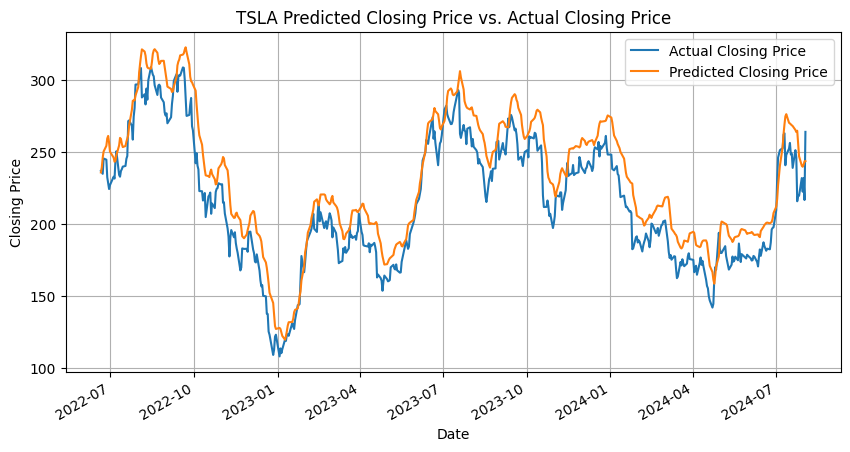

In [14]:
# Plot the predictions
p3utils.plot_predictions(df=stock_df, 
                 ticker_symbol=ticker_symbol,
                 show_all=False).show()

In [7]:
# Now test if the model worked:
(total_profit, final_actual_price, final_actual_profit) = p3utils.score_the_model(stock_df, "2024-01-01", "2024-07-31")
print("Real World Gains: ",final_actual_profit)
print("Profit made using this model: ",total_profit)
print('Percent improvement over "do nothing": ', total_profit/final_actual_profit*100)


Real World Gains:  -27.460006713867188
Profit made using this model:  788.9380021856834
Percent improvement over "do nothing":  -2873.043733770368


In [8]:
# Finally, let's write this data to a file for reference later
stock_df.to_csv(f'Saved_Predictions/{ticker_symbol}-Predictions-{unixtime}.csv')